### Imports

In [1]:
import pandas as pd
import numpy as np
from math import fabs
from sklearn.metrics import r2_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import neighbors, tree, svm
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error    
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import brier_score_loss
import warnings
warnings.filterwarnings('ignore')

### Loading and Cleaning dataset

In [2]:
df = pd.read_csv("../Data/selected.csv", index_col = False)
df.drop(["Unnamed: 0"], inplace = True, axis = 1)
df = df.replace(' NA', np.nan)
df = df.replace('NA', np.nan)
df['NPI'] = df['NPI'].astype('float')
df['NPI'].replace(np.nan, df['NPI'].mean(), inplace = True)
df.head()

,219340_s_at,217771_at,202418_at,206295_at,201091_s_at,204015_s_at,200726_at,200965_s_at,210314_x_at,221882_s_at,...,t.dmfs,e.dmfs,t.tdm,e.tdm,risksg,NPI,risknpi,AOL_os_10y,risk_AOL,veridex_risk
0,7.014110,9.938705,11.053083,5.326001,10.964107,6.244280,10.926361,8.962608,10.523859,10.926365,...,723,1,723,1,2,4.60,2,62.7,1,Poor
1,7.326724,6.374728,10.596457,8.290123,11.594716,6.542130,12.242090,9.531718,10.342614,9.555092,...,6591,0,6591,0,2,4.60,2,69.0,1,Poor
2,6.974651,9.226757,10.834848,5.731169,9.166088,6.586000,11.661716,10.238680,10.144875,9.308048,...,524,1,524,1,2,4.50,2,66.2,1,Poor
3,7.703683,8.169183,11.627066,8.538247,9.086937,8.477335,12.174021,9.819279,10.888251,10.208241,...,6255,1,6255,0,2,4.36,2,84.9,1,Poor
4,6.581141,7.496745,11.500773,5.979282,8.887616,7.398170,11.484011,11.489233,9.702690,10.931843,...,3822,1,3822,1,2,3.60,2,80.2,1,Poor


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ff6b87370>]],
      dtype=object)

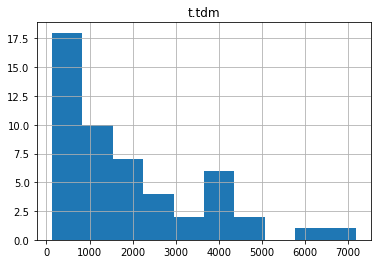

In [3]:
df[df["e.tdm"]==1][["t.tdm"]].hist()

### Choosing columns for training

In [4]:
num_censored, num_events = len(df) - df["e.tdm"].sum(), df["e.tdm"].sum()
fraction_censored = num_censored/len(df)

In [5]:
df["weights"] = pd.Series([1 if i==1 else fraction_censored for i in df["e.tdm"]])
# df["weights"] = df["weights"]/df["weights"].sum()

In [6]:
df["weights"].sort_values()

197    0.742424
99     0.742424
100    0.742424
101    0.742424
102    0.742424
         ...   
76     1.000000
75     1.000000
73     1.000000
69     1.000000
98     1.000000
Name: weights, Length: 198, dtype: float64

In [7]:
removals = ['t.rfs', 'e.rfs', 't.os', 'e.os', 't.dmfs','e.dmfs', 't.tdm', 'e.tdm', "samplename", "id","filename","hospital", 'Surgery_type', 'Histtype', 'Angioinv', 'Lymp_infil', 'node', 'grade', 'er', 'risksg', 'risknpi', 'risk_AOL', 'veridex_risk']
rest = [i for i in df.columns if i not in removals]

In [8]:
X = df[rest]
y = df["t.tdm"]

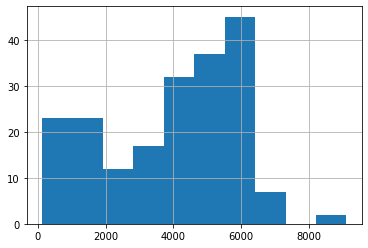

In [9]:
y.hist()

### Defining Indicator Functions

In [10]:
steps = 100
indicators = np.arange(0,10000,steps)

for indicator in indicators:
    df['indi_'+str(indicator)]= y < indicator
    

### Train-Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, df[['indi_'+str(indicator) for indicator in indicators]], test_size=0.33, random_state=42)
columns = y_train.columns

In [12]:
X_cols = list(set(X_train.columns) - set(["weights"]))

In [13]:
accs = []
for i,column in enumerate(columns):
    if( y_train[column].nunique()==1):
        y_test["prob_" + column] = 0
        y_test["survival_simple_" + column] = 1
        y_test["survival_log_" + column] = 0
        y_test["hazard_" + column] = 0
        continue
        
    clf = LogisticRegression(random_state=0,solver='liblinear')
    clf.fit(X_train[X_cols], y_train[column], sample_weight = X_train["weights"])
    y_test["prob_" + column] = clf.predict_proba(X_test[X_cols])[:,1]
    accs.append(clf.score(X_test[X_cols], y_test[column], sample_weight = X_test["weights"]))
    if(i>1):
        y_test["prob_" + column] =  np.maximum(y_test["prob_" + columns[i-1]],y_test["prob_" + column])
        y_test["survival_simple_" + column] = 1 - y_test["prob_" + column]
        
        y_test["survival_log_" + column] = np.log(y_test["survival_simple_" + column])
        y_test["hazard_" + column] = ( - y_test["survival_log_" + columns[i]] + y_test["survival_log_" + columns[i-1]])/steps
print(np.mean(accs))

0.7387556076934976


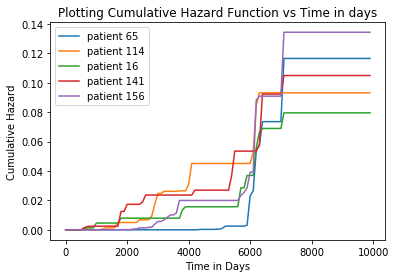

In [14]:
plt.figure()
for i in range(5):
    plt.plot(indicators, y_test.iloc[i,:][y_test.columns[y_test.columns.str.startswith("hazard_")]].cumsum(), label=f"patient {X_test.iloc[i].name}")
    
plt.xlabel('Time in Days')
plt.ylabel('Cumulative Hazard')
plt.xlabel('Time in Days')
plt.title("Plotting Cumulative Hazard Function vs Time in days")
plt.legend()

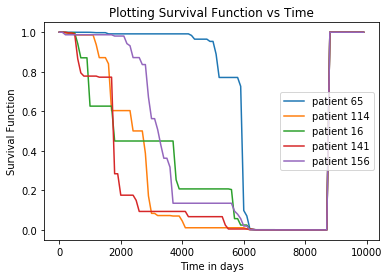

In [15]:
plt.figure()
for i in range(5):
    plt.plot(indicators, y_test.iloc[i,:][y_test.columns[y_test.columns.str.startswith("survival_simple_")]], label=f"patient {X_test.iloc[i].name}")
#plt.xlim([0,4000])
plt.xlabel("Time in days")
plt.ylabel("Survival Function")
plt.title("Plotting Survival Function vs Time")
plt.legend()

### Implementing Cobra

In [16]:
models = {"svc": svm.SVC, "knn": neighbors.KNeighborsClassifier, "dt": tree.DecisionTreeClassifier, "logreg": LogisticRegression, "gaussnb": GaussianNB, "lda": LinearDiscriminantAnalysis}

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, df[['indi_'+str(indicator) for indicator in indicators]], test_size=0.2, random_state=42)
columns = y_train.columns

## Cobra Estimator Class

In [18]:
class NaiveCobra(BaseEstimator):
    """ Naive version of cobra which calculates aggregates for prediction."""
    def __init__(self, eps=None):
        ## Defining Parameters
        self.eps = eps
        self.machines = {}
        self.models = {'svc': svm.SVC,
                     'knn': neighbors.KNeighborsClassifier,
                     'dt': tree.DecisionTreeClassifier,
                     'logreg': LogisticRegression,
                     'gaussnb': GaussianNB,
                     'lda': LinearDiscriminantAnalysis}
        self.alpha = len(self.models)
    
    def fit(self, X_train, y_train):
        # Fitting each of the models, sample_weight = self.X_k["weights"]
        for model_name in self.models:
            if model_name == "logreg":
                self.machines[model_name] = models[model_name](solver = 'liblinear').fit(X_train[X_cols], y_train, sample_weight = X_train["weights"])
            elif model_name =='svc':
                self.machines[model_name] = models[model_name](probability = True).fit(X_train[X_cols], y_train, sample_weight = X_train["weights"])
            else:
                self.machines[model_name] = models[model_name]().fit(X_train[X_cols], y_train, sample_weight = X_train["weights"])
        
        return self
    def predict(self, X_test):
        # Genarating Predictions from trained regressors.
        self.machine_predictions_ = {}
        self.all_predictions_ = []
        for machine_name in self.machines:
            self.machine_predictions_[machine_name] = self.machines[machine_name].predict_proba(X_test)[:,1]
            self.all_predictions_.append(self.machine_predictions_[machine_name])
        self.all_predictions_= np.array(self.all_predictions_)
        selection_table = np.zeros((len(X_test), self.alpha))
        
        for machine_index, machine_name in enumerate(self.models.keys()):
            predicted_val = self.machines[machine_name].predict_proba(X_test)[:,1]

            for ind in range(0, len(X_test)):
                if fabs(self.machine_predictions_[machine_name][ind] - predicted_val[ind]) <= self.eps:
                    selection_table[ind][machine_index] = 1


        
        predicted_vals = []
        for ind in range(len(X_test)):
            if(np.sum(selection_table[ind]) == self.alpha):
                predicted_vals.append(np.mean(self.all_predictions_[:, ind]))
                
            else:
                predicted_vals.append(0)
        return np.array(predicted_vals)

In [19]:
class VenomCobra(BaseEstimator):
    """ Cobra implementation using voting mechanism."""
    def __init__(self, eps=None):
        ## Defining Parameters
        self.eps = eps
        self.machines = {}
        self.models = {'svc': svm.SVC,
                     'knn': neighbors.KNeighborsClassifier,
                     'dt': tree.DecisionTreeClassifier,
                     'logreg': LogisticRegression,
                     'gaussnb': GaussianNB,
                     'lda': LinearDiscriminantAnalysis}
        self.alpha = len(self.models)
        
    def __split_train_data(self, X, y, split_ratio):
        
        
        combined = pd.concat([X,y], axis =1)
        combined_0 = combined[combined.iloc[:,-1]==0]
        combined_1 = combined[combined.iloc[:,-1]==1]
        k_0 = int(split_ratio*len(combined_0))
        k_1 = int(split_ratio*len(combined_1))
        
        X_k = pd.concat([combined_0.iloc[:k_0,:-1], combined_1.iloc[:k_1,:-1]])
        y_k = pd.concat([combined_0.iloc[:k_0,-1], combined_1.iloc[:k_1,-1]])
        X_l = pd.concat([combined_0.iloc[k_0+1:,:-1], combined_1.iloc[k_1+1:,:-1]])
        y_l = pd.concat([combined_0.iloc[k_0+1:,-1], combined_1.iloc[k_1+1:,-1]])

        return X_k, y_k, X_l, y_l

    def fit(self, X, y):
        self.X = X
        self.y = y
        self.X_k, self.y_k, self.X_l, self.y_l = self.__split_train_data(self.X, self.y, 0.5)
        
        # Fitting each of the models
        for model_name in self.models:
            if model_name == "logreg":
                self.machines[model_name] = models[model_name](solver = 'liblinear').fit(self.X_k[X_cols], self.y_k, sample_weight = self.X_k["weights"])
            elif model_name =='svc':
                self.machines[model_name] = models[model_name](probability = True).fit(self.X_k[X_cols], self.y_k, sample_weight = self.X_k["weights"])
            elif model_name =='knn' or model_name == 'lda':
                self.machines[model_name] = models[model_name]().fit(self.X_k[X_cols], self.y_k)
            else:
                self.machines[model_name] = models[model_name]().fit(self.X_k[X_cols], self.y_k, sample_weight = self.X_k["weights"])
        self.generate_predictions()
        return self
    def generate_predictions(self):
        self.machine_predictions = {}
        self.all_predictions = np.array([])
        for machine_name in self.machines:
            self.machine_predictions[machine_name] = self.machines[machine_name].predict_proba(self.X_l[X_cols])[:,1]
            self.all_predictions = np.append(self.all_predictions, self.machine_predictions[machine_name])
            
    def optimal_threshold(self, num_grid_points=10):

        if self.eps is None:
#             a, size = sorted(self.all_predictions), len(self.all_predictions)
#             res = [a[i + 1] - a[i] for i in range(size) if i+1 < size]
            emin = 0.1
            emax = 1
            erange = np.linspace(emin, emax, num_grid_points)
            tuned_params = [{'eps': erange}]
            print("Grid Search Start")
            briers = []
            for eps in erange:
                self.eps = eps
                self.fit(self.X, self.y)
                preds = self.predict(self.X_l)
                preds[preds > 0.5] = 1
                preds[preds <= 0.5] = 0
                briers.append(accuracy_score(self.y_l, preds))
            self.eps = erange[np.argmax(briers)]
            # GridSearchCV uses 5-fold cross validation by default.
#             clf = GridSearchCV(self, tuned_params, scoring="neg_brier_score", n_jobs=-1)
#             clf.fit(X, y)
#             
#             self.eps = clf.best_params_["eps"]  
            print("Grid Search Complete, eps: ", self.eps)
            
    def predict(self, X_test):
        # Genarating Predictions from trained regressors.
        preds = []
        for x in X_test[X_cols].values:
            x = np.array(x)
            x = x.reshape(1, -1)
            selection_table = np.zeros((len(self.X_l), self.alpha))
        
            for machine_index, machine_name in enumerate(self.models.keys()):
                predicted_val = self.machines[machine_name].predict_proba(x)[:,1]

                for ind in range(0, len(self.X_l)):
                    if fabs(self.machine_predictions[machine_name][ind] - predicted_val) <= self.eps:
                        selection_table[ind][machine_index] = 1


            selected_indices = []
            

            for ind in range(len(self.X_l)):
                if(np.sum(selection_table[ind]) == self.alpha):
                    selected_indices.append(ind)
            
            pred = 0
            weight_sum =0
            for ind in selected_indices:
                pred+=self.y_l.iloc[ind]*self.X_l["weights"].iloc[ind]
                weight_sum +=self.X_l["weights"].iloc[ind]
            if (len(selected_indices)!=0):
                pred/=weight_sum
#                 pred/=len(selected_indices)
            preds.append(pred)
        return np.array(preds)

In [20]:
accs = []
briers = []
for i,column in enumerate(columns):
    
    if( y_train[column].nunique()==1 or y_train[column].value_counts()[0] ==1 or y_train[column].value_counts()[1] ==1):
        y_test["prob_" + column] = 0
        y_test["survival_simple_" + column] = 1
        y_test["survival_log_" + column] = 0
        y_test["hazard_" + column] = 0
        continue

#     cobra = VenomCobra(eps = None)#0.95)
    cobra = VenomCobra(eps = 0.1)
    cobra = cobra.fit(X_train, y_train[column])
#     cobra.optimal_threshold()
#     cobra.fit(X_train, y_train[column])
    preds = cobra.predict(X_test)
    y_test["prob_" + column] = preds
    briers.append(brier_score_loss(y_test[column],preds))
    preds[preds > 0.5] = 1
    preds[preds <= 0.5] = 0
    accs.append(accuracy_score(preds, y_test[column]))
    if(i>1):
        y_test["prob_" + column] =  np.maximum(y_test["prob_" + columns[i-1]],y_test["prob_" + column])
        y_test["survival_simple_" + column] = 1 - y_test["prob_" + column]
        
        y_test["survival_log_" + column] = np.log(y_test["survival_simple_" + column])
        y_test["hazard_" + column] = ( - y_test["survival_log_" + columns[i]] + y_test["survival_log_" + columns[i-1]])/steps
print(np.mean(accs))
np.mean(briers)

0.7238235294117645


0.2602553967095477

## Plots

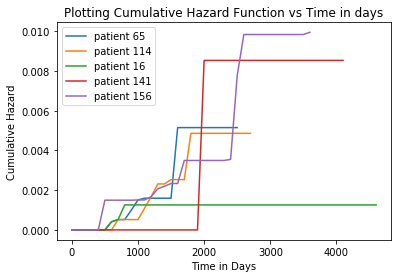

In [21]:
plt.figure()
for i in range(5):
    plt.plot(indicators, y_test.iloc[i,:][y_test.columns[y_test.columns.str.startswith("hazard_")]].cumsum(), label=f"patient {X_test.iloc[i].name}")
    
plt.xlabel('Time in Days')
plt.ylabel('Cumulative Hazard')
plt.xlabel('Time in Days')
plt.title("Plotting Cumulative Hazard Function vs Time in days")
plt.legend()

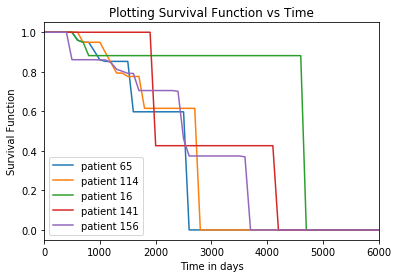

In [22]:
plt.figure()
for i in range(5):
    plt.plot(indicators, y_test.iloc[i,:][y_test.columns[y_test.columns.str.startswith("survival_simple_")]], label=f"patient {X_test.iloc[i].name}")
plt.xlim([0,6000])
plt.xlabel("Time in days")
plt.ylabel("Survival Function")
plt.title("Plotting Survival Function vs Time")
plt.legend()

In [23]:
models = {'svc': svm.SVC,
                     'knn': neighbors.KNeighborsClassifier,
                     'dt': tree.DecisionTreeClassifier,
                     'logreg': LogisticRegression,
                     'gaussnb': GaussianNB,
                     'lda': LinearDiscriminantAnalysis}

In [24]:
model_accs = []
for model in models.values():
    
    print(model)
    
    accs = []
    briers = []
    
    for i,column in enumerate(columns):

        if( y_train[column].nunique()==1 or y_train[column].value_counts()[0] ==1 or y_train[column].value_counts()[1] ==1):
            y_test["prob_" + column] = 0
            y_test["survival_simple_" + column] = 1
            y_test["survival_log_" + column] = 0
            y_test["hazard_" + column] = 0
            continue

        cobra = model()
        cobra = cobra.fit(X_train, y_train[column])
        preds = cobra.predict(X_test)
        
        y_test["prob_" + column] = preds
        
        briers.append(brier_score_loss(y_test[column],preds))
        
        preds[preds > 0.5] = 1
        preds[preds <= 0.5] = 0
        accs.append(accuracy_score(preds, y_test[column]))
        
        if(i>1):
            y_test["prob_" + column] =  np.maximum(y_test["prob_" + columns[i-1]],y_test["prob_" + column])
            y_test["survival_simple_" + column] = 1 - y_test["prob_" + column]

            y_test["survival_log_" + column] = np.log(y_test["survival_simple_" + column])
            y_test["hazard_" + column] = ( - y_test["survival_log_" + columns[i]] + y_test["survival_log_" + columns[i-1]])/steps
    
    model_accs.append(np.mean(briers))
    print(np.mean(accs))
    

<class 'sklearn.svm._classes.SVC'>
0.7844117647058824
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
0.7855882352941177
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
0.7952941176470587
<class 'sklearn.linear_model._logistic.LogisticRegression'>
0.768235294117647
<class 'sklearn.naive_bayes.GaussianNB'>
0.8467647058823529
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
0.8138235294117647


In [25]:
model_accs.append(0.665)
model_accs.append(0.795)
model_accs

[0.2155882352941176,
 0.21441176470588236,
 0.20470588235294115,
 0.23176470588235293,
 0.15323529411764705,
 0.18617647058823528,
 0.665,
 0.795]

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

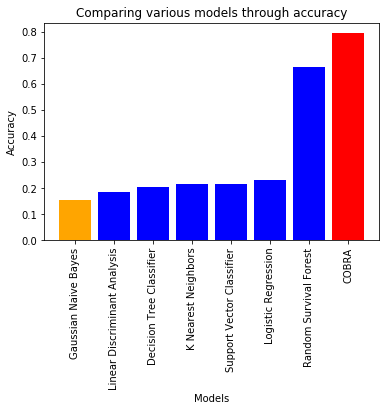

In [26]:
xlabels = ['Support Vector Classifier', 'K Nearest Neighbors', 'Decision Tree Classifier', 'Logistic Regression', 'Gaussian Naive Bayes', 'Linear Discriminant Analysis', 'Random Survival Forest', 'COBRA']
idx = np.argsort(model_accs)
plt.bar(np.array(xlabels)[idx], np.array(model_accs)[idx], color = ['orange', 'blue', 'blue', 'blue', 'blue',  'blue', 'blue', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparing various models through accuracy')
plt.xticks(rotation = 90)

In [27]:
model_accs.append(0.148)

In [28]:
xlabels = ['Support Vector Classifier', 'K Nearest Neighbors', 'Decision Tree Classifier', 'Logistic Regression', 'Gaussian Naive Bayes', 'Linear Discriminant Analysis',  'COBRA']
idx = np.argsort(model_accs)
plt.bar(np.array(xlabels)[idx], np.array(model_accs)[idx], color = ['red','blue', 'blue', 'blue', 'blue',  'blue', 'blue'])
plt.xlabel('Models')
plt.ylabel('Brier Score')
plt.title('Comparing various models through Brier Score')
plt.xticks(rotation = 90)

IndexError: index 8 is out of bounds for axis 0 with size 7

In [ ]:
idx = np.argsort(model_accs)
idx